**High Level Process Overview**

Data Cleaning
- remove observations with missing target (no created_at or actual_delivery_time measurements)
- check for duplicates

Split data into train/test
- must occur after data cleaning, PRIOR to any EDA or modeling to prevent data leakage
- 80/20 train/test (shuffle prior to split)

EDA & Feature Engineering
- check missing data
- univariate, bivariate feature analysis
    - stratified by target
- collinearity (among numeric features)
- feature engineering (creation of new features derived from original set)

Modeling & Evaluation will be taken care of in separate notebooks, after we prep the data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
data_path = '../datasets/historical_data.csv'

df = pd.read_csv(data_path)

df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

Data Cleaning:
- check duplicates
- check for missing target values

In [5]:
print(f"Number of duplicates: {df.duplicated().sum()} \n")

print(pd.DataFrame({'Missing Count': df[['created_at', 'actual_delivery_time']].isna().sum()}))

Number of duplicates: 0 

                      Missing Count
created_at                        0
actual_delivery_time              7


Remove rows with missing delivery time
- cannot compute time to delivery without final delivery time

In [6]:
df = df.dropna(subset=['actual_delivery_time'])

df[['created_at', 'actual_delivery_time']].isna().sum()

created_at              0
actual_delivery_time    0
dtype: int64

Create target:
- actual_delivery_time - created_at

In [7]:
# convert columns to datetime 
df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], utc=True)

# create prediction target
df['seconds_to_delivery'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds()

Let's check for missing data in our feature space.

If a high percentage of data is missing for a feature, we may decide to drop that feature altogether. Otherwise, we should decide how to deal with those observations (removal, imputation, etc.)

In [8]:
df.isna().mean()

market_id                                       0.004999
created_at                                      0.000000
actual_delivery_time                            0.000000
store_id                                        0.000000
store_primary_category                          0.024111
order_protocol                                  0.005040
total_items                                     0.000000
subtotal                                        0.000000
num_distinct_items                              0.000000
min_item_price                                  0.000000
max_item_price                                  0.000000
total_onshift_dashers                           0.082372
total_busy_dashers                              0.082372
total_outstanding_orders                        0.082372
estimated_order_place_duration                  0.000000
estimated_store_to_consumer_driving_duration    0.002664
seconds_to_delivery                             0.000000
dtype: float64

Among the market features (onshift_dashers, busy_dashers, outstanding_orders), approximately 8% of observations are missing data.

The feature with the second-highest missing data rate is store_primary_category (~2%). All other features have < 1% missing.

Thus, we won't remove any features. Later on, we will look at the feature distributions to help us decide how to deal with those missing observations.

But first, let's split our data into train/test. We will proceed with an 80/20 split.

In [9]:
from sklearn.model_selection import train_test_split

# shuffle
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

# split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
assert len(train_df) + len(test_df) == len(df)

We'll write this test set to a separate file, which we won't touch until final model evaluation.

In [11]:
test_data_path = '../datasets/test_data.csv'

test_df.to_csv(test_data_path, index=False)

Let's look at our train data.

In [12]:
train_df.describe()

,market_id,store_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,seconds_to_delivery
count,157163.000000,157936.000000,157150.000000,157936.000000,157936.000000,157936.000000,157936.000000,157936.000000,144950.000000,144950.000000,144950.000000,157936.000000,157504.000000,1.579360e+05
mean,2.978952,3529.304756,2.882724,3.198916,2681.604751,2.669911,685.978137,1159.269115,44.760442,41.702546,57.999621,308.679269,545.525523,2.921589e+03
std,1.525018,2053.200077,1.505622,2.702352,1820.348842,1.627428,520.334324,557.795264,34.504193,32.138243,52.643854,89.864171,219.293580,2.149131e+04
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,0.000000,0.000000,1.010000e+02
25%,2.000000,1686.000000,1.000000,2.000000,1400.000000,1.000000,299.000000,799.000000,17.000000,15.000000,17.000000,251.000000,383.000000,2.105000e+03
50%,3.000000,3581.000000,3.000000,3.000000,2200.000000,2.000000,595.000000,1095.000000,37.000000,34.000000,41.000000,251.000000,544.000000,2.662000e+03
75%,4.000000,5299.000000,4.000000,4.000000,3395.000000,3.000000,949.000000,1395.000000,65.000000,62.000000,85.000000,446.000000,702.000000,3.384000e+03
max,6.000000,6987.000000,7.000000,411.000000,27100.000000,20.000000,8999.000000,8999.000000,171.000000,154.000000,285.000000,1740.000000,2088.000000,8.516859e+06


In [13]:
train_df.dtypes

market_id                                                   float64
created_at                                      datetime64[ns, UTC]
actual_delivery_time                            datetime64[ns, UTC]
store_id                                                      int64
store_primary_category                                       object
order_protocol                                              float64
total_items                                                   int64
subtotal                                                      int64
num_distinct_items                                            int64
min_item_price                                                int64
max_item_price                                                int64
total_onshift_dashers                                       float64
total_busy_dashers                                          float64
total_outstanding_orders                                    float64
estimated_order_place_duration                  

Let's establish our categorical vs. numeric features.

In [14]:
categorical_feats = [
    'market_id',
    'store_id',
    'store_primary_category',
    'order_protocol'
]

numeric_feats = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'min_item_price',
    'max_item_price',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders', 
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration'
]

Let's revisit the categorical features with missing values (market_id, store_primary_category, order_protocol).

Since there was little missing data (<3% missing among those features), we will simply impute those missing values with an "unknown" category.
- This way we don't have to remove data from other features, and perhaps the absence of feature values holds some predictive power.
- We will add this imputation step to our preprocessing pipeline for modeling.

In [15]:
missing_cols_categorical = ['market_id', 'store_primary_category', 'order_protocol']

train_df[missing_cols_categorical] = train_df[missing_cols_categorical].fillna("unknown")

Let's look at our categorical variables.

In [16]:
pd.DataFrame({'Cardinality': train_df[categorical_feats].nunique()}).rename_axis('Feature')

,Cardinality
Feature,
market_id,7
store_id,6600
store_primary_category,75
order_protocol,8


Since market_id & order_protocol have low cardinality, we can visualize their distributions easily.

On the other hand, store_id & store_primary_category are high cardinality features. We'll take a deeper look at those later.

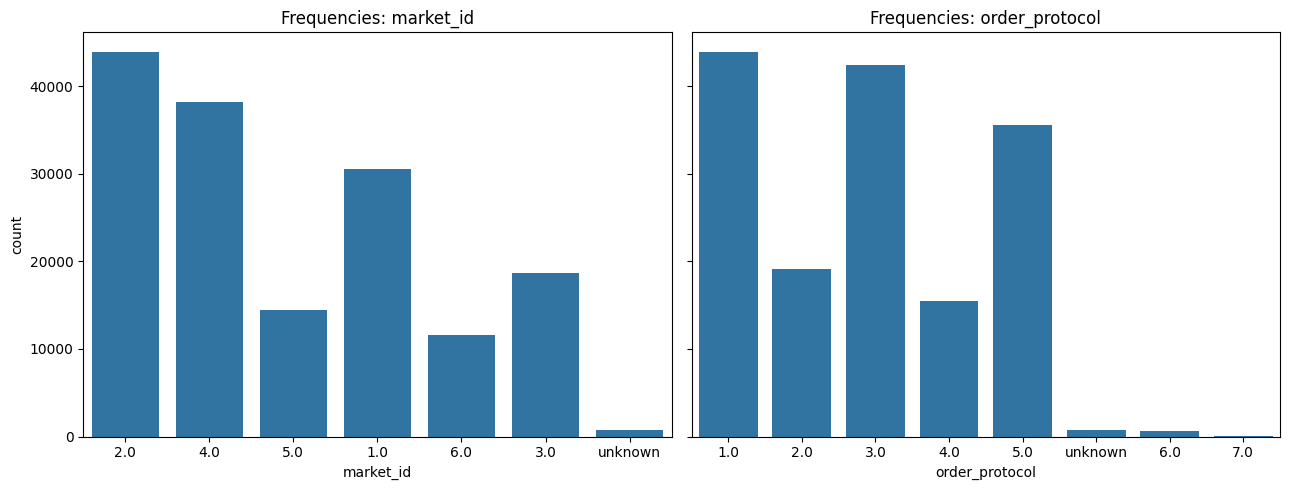

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

categorical_feats_subset = [
    'market_id',
    'order_protocol'
]

# Set up the grid
fig, axes = plt.subplots(1, len(categorical_feats_subset), figsize=(13, 5), sharey=True)

# Create barplots for each variable
for i, col in enumerate(categorical_feats_subset):
    sns.countplot(x=col, data=train_df, ax=axes[i])
    axes[i].set_title(f"Frequencies: {col}")

# Adjust layout
plt.tight_layout()
plt.show()

- ~70% of orders placed in market_ids 1, 2, 4
- < 1% of orders of order_protocol type 6 or 7


Does each store_primary_category have an associated store_id range?

If so, we may not need store_id, as store_primary_category would encapsulate a lot of that information.

In [18]:
store_info = train_df[['store_id', 'store_primary_category']]

store_info.groupby('store_primary_category')['store_id'].agg(['min', 'max'])

,min,max
store_primary_category,,
afghan,474,6475
african,3385,6865
alcohol,28,6965
alcohol-plus-food,2278,2278
american,16,6987
...,...,...
turkish,221,6774
unknown,4,6984
vegan,474,6944


No - store_ids overlap across categories.

Let's look at store_id & store_primary_category.

In [19]:
train_df['store_id'].value_counts()

store_id
6865    746
1311    677
314     645
1686    634
3937    594
       ... 
2087      1
4318      1
4267      1
1720      1
2386      1
Name: count, Length: 6600, dtype: int64

In [20]:
train_df['store_primary_category'].value_counts()

store_primary_category
american             15574
pizza                13794
mexican              13677
burger                8746
sandwich              8106
                     ...  
african                  7
belgian                  2
indonesian               2
alcohol-plus-food        1
chocolate                1
Name: count, Length: 75, dtype: int64

We see that store_id & store_primary_category have high cardinality, where many of the values may only have a few observations associated with them.

High cardinality categorical features may be problematic in regression tasks - when encoded, they may enlarge the feature space drastically, making the available data sparse (curse of dimensionality).

So, let's visualize these frequencies to get a sense of how sparsely distributed these features are.

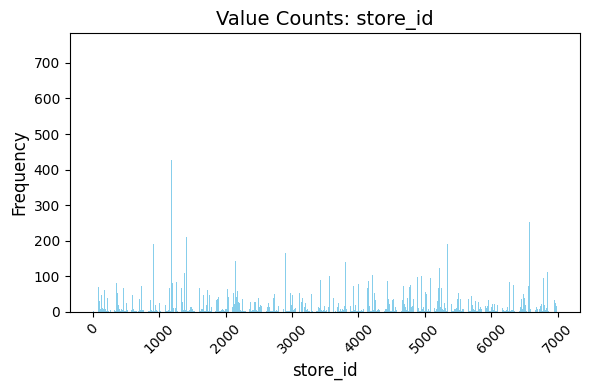

In [21]:
store_id_values = train_df['store_id'].value_counts()

# Plot the histogram
plt.figure(figsize=(6, 4))
plt.bar(store_id_values.index, store_id_values.values, color='skyblue')

# Add titles and labels
plt.title('Value Counts: store_id', fontsize=14)
plt.xlabel('store_id', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

We will group store_id values by frequency. Concretely, we'll group store_ids into the following percentile bins:
- [0-50) percentile
- [50-75) percentile
- [75-99) percentile
- 99+ percentile

This will reduce dimensionality of the feature, while retaining relevant information related to store_id popularity.

Inspiration: https://www.linkedin.com/advice/0/how-do-you-deal-categorical-features-high-cardinality#:~:text=One%20way%20to%20reduce%20the,Tashi%20Tamang

*Note: we will have to do this encoding for our test data.*

In [22]:
import sys
sys.path.append('../utils')
import feature_eng_utils

In [23]:
from feature_eng_utils import encode_frequency

value_counts = train_df['store_id'].value_counts()
percentiles = np.percentile(value_counts, [50, 75, 90, 99]) 

# apply encode_frequency to each store_id based on their number of orders
train_df['store_id_freq'] = train_df['store_id'].apply(lambda x: encode_frequency(value_counts[x], percentiles))

pd.DataFrame({'Count':train_df['store_id_freq'].value_counts()}).rename_axis('Frequency Bin')

,Count
Frequency Bin,
[90-99),60612
[75-90),36854
[50-75),26215
99+,22454
[0-50),11801


Let's look at store_primary_category.

In [24]:
pd.set_option('display.max_rows', None)

train_df['store_primary_category'].value_counts()

store_primary_category
american             15574
pizza                13794
mexican              13677
burger                8746
sandwich              8106
chinese               7511
japanese              7354
dessert               7010
fast                  5922
indian                5840
thai                  5793
italian               5740
vietnamese            4851
mediterranean         4355
breakfast             4331
unknown               3761
other                 3221
salad                 2987
greek                 2692
seafood               2203
barbecue              2164
asian                 1964
cafe                  1804
sushi                 1758
alcohol               1509
korean                1468
smoothie              1310
catering              1268
middle-eastern        1198
hawaiian              1191
steak                  904
dim-sum                890
vegetarian             667
burmese                645
pasta                  513
persian                482
frenc

Many of these primary categories aren't exclusive of each other.
- ex: american & burger, asian & korean

So, let's map these distinct categories into fewer, broader groups.

The following grouping is certainly not the only option. There may be better ways to group cuisine categories, but I'm proceeding with the following grouping for simplicity.

*Note: we will have to do this encoding for our test data.*

In [25]:
from feature_eng_utils import map_to_category_type

train_df['store_category_type'] = train_df['store_primary_category'].apply(lambda x: map_to_category_type(x))

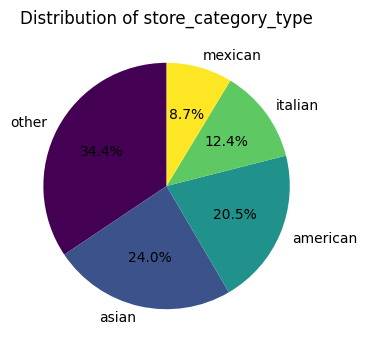

In [26]:
value_counts = train_df['store_category_type'].value_counts()

# Plot pie chart
plt.figure(figsize=(4, 4))
value_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis', labels=value_counts.index)
plt.title('Distribution of store_category_type')
plt.ylabel('')  # Hide y-axis label for aesthetics
plt.show()

Now, let's get a sense of what the distributions look like for our numeric features.

Depending on the distributions, we will decide how to impute or remove observations with missing values for each of the features.

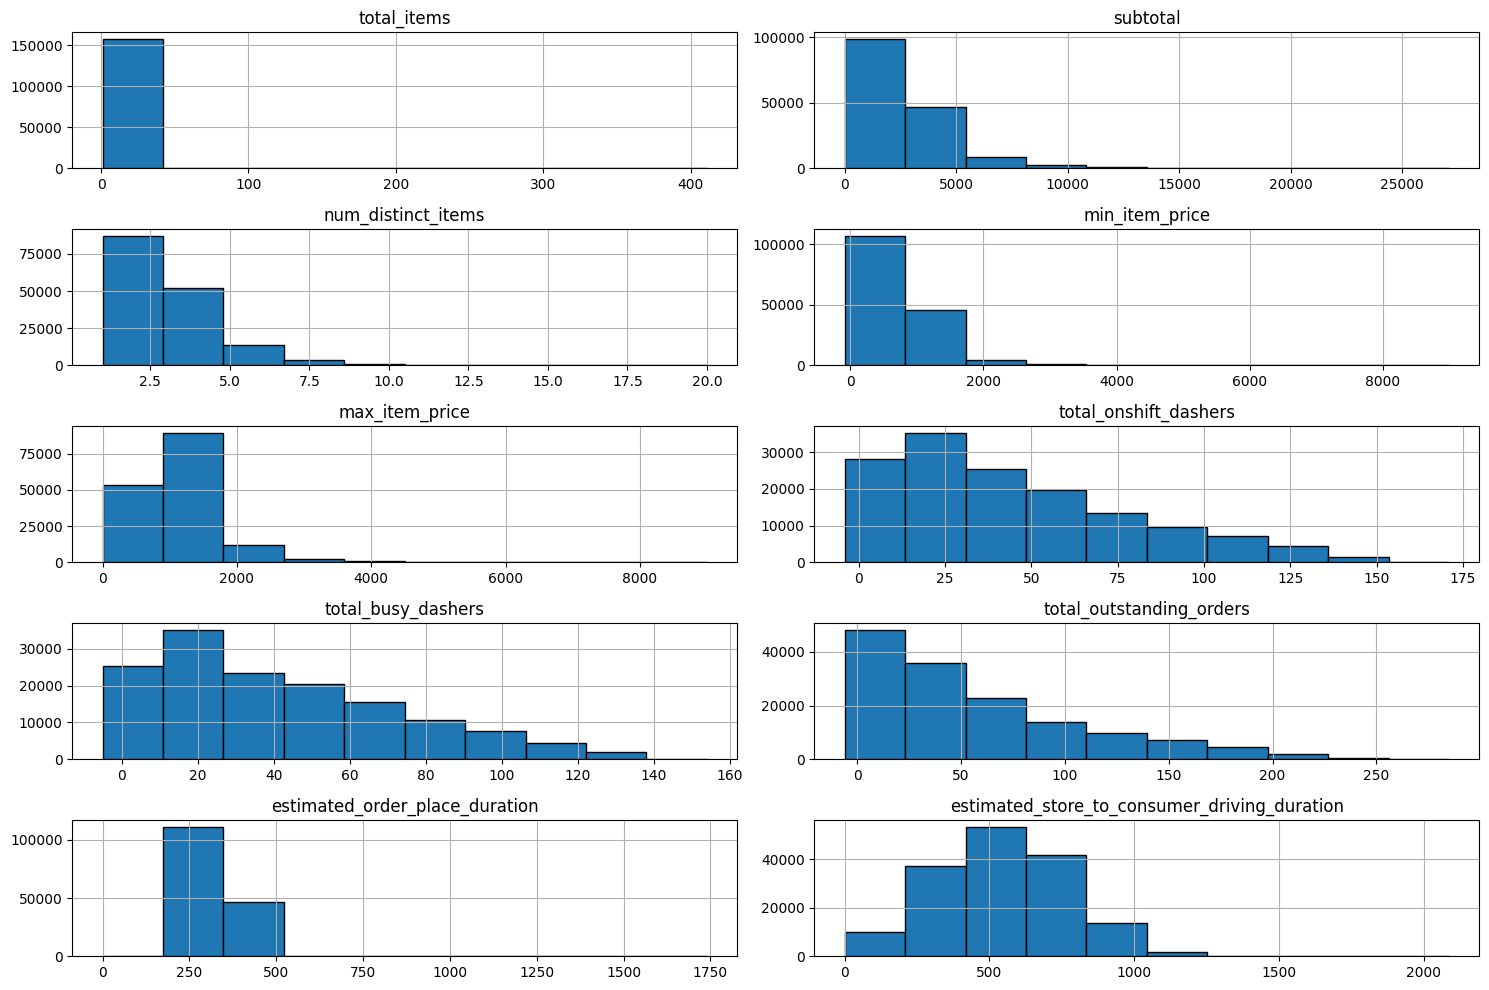

In [27]:
train_df[numeric_feats].hist(bins=10, figsize=(15, 10), layout=(5, 2), edgecolor='black')
plt.tight_layout()
plt.show()

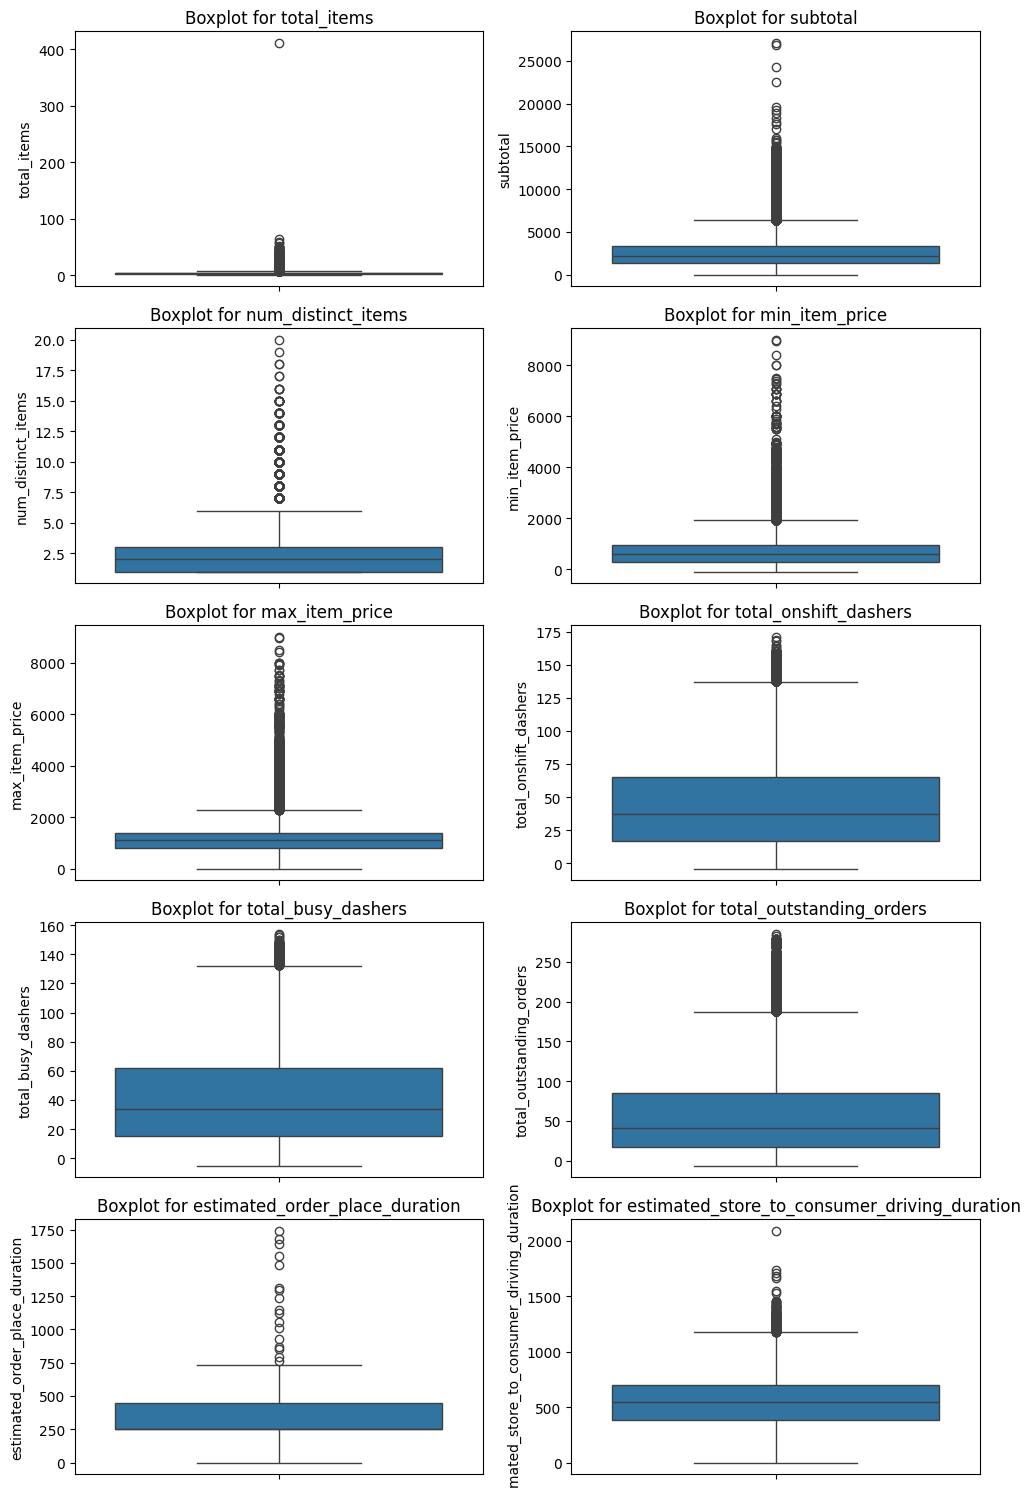

In [28]:
# Create grid for boxplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))  # Adjust figure size
axes = axes.flatten()  # Flatten the 5x2 axes into a 1D array for easier iteration

# Generate boxplots for each numeric feature
for i, column in enumerate(numeric_feats):
    sns.boxplot(y=train_df[column], ax=axes[i])
    axes[i].set_title(f"Boxplot for {column}")
    axes[i].set_ylabel(column)

# Remove any unused subplots (if any)
for i in range(len(numeric_feats), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

Many of these distributions are right skewed, or appear to be right skewed due to outliers.

In particular, there seems to be an order with 400 items. This seems strange since the next highest order is less than 100 items.

In [29]:
train_df['total_items'].sort_values(ascending=False).head(10)

168566    411
176375     64
56546      59
49893      56
8268       51
8340       50
90742      49
38099      49
18696      48
171021     48
Name: total_items, dtype: int64

Let's look at that order with 411 items.

In [30]:
train_df[train_df['total_items']==train_df['total_items'].max()]

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,seconds_to_delivery,store_id_freq,store_category_type
168566,2.0,2015-02-06 00:42:39+00:00,2015-02-06 01:33:34+00:00,777,fast,4.0,411,3115,5,0,299,35.0,35.0,39.0,251,573.0,3055.0,[75-90),other


That order was a fast-food order that consisted of 411 total items, but only 5 distinct items. It was also placed late at night (midnight-1 am).

While it's not impossible for somebody to place an order like that, we'll proceed to remove this observation from our data since it's highly unlikely that our model will have to make a prediction for an order for that many items.

In [31]:
train_df.drop(train_df['total_items'].idxmax(), inplace=True)

In [32]:
train_df['total_items'].sort_values(ascending=False).head(5)

176375    64
56546     59
49893     56
8268      51
8340      50
Name: total_items, dtype: int64

Notice that we have a min_item_price & max_item_price.

We can use these columns to compute the price range between the least & most expensive items in the order. 

This would consolidate information from both features into a single feature. 

*Note: we will have create this feature for our test data.*

In [33]:
train_df['item_price_range'] = train_df['max_item_price'] - train_df['min_item_price']

train_df[['max_item_price', 'min_item_price', 'item_price_range']].head()

,max_item_price,min_item_price,item_price_range
70517,679,0,679
50628,2249,1499,750
57319,599,599,0
52854,995,995,0
35922,479,399,80


It seems like time of day when order was placed would be relevant information for predicting time to delivery.

Thus, let's extract the time of day info from the order placement time (created_at).

In [34]:
time_info = train_df['created_at'].astype(str).str.split().str[1]
train_df['hour_of_day'] = time_info.str.split(":").str[0]

Let's look at how Delivery Duration varies by Hour of Day.

<Axes: xlabel='hour_of_day', ylabel='seconds_to_delivery'>

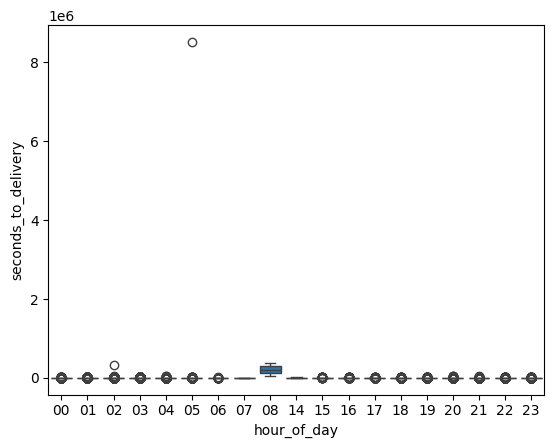

In [35]:
sns.boxplot(data=train_df, x="hour_of_day", y="seconds_to_delivery", order=sorted(train_df["hour_of_day"].unique()))

It's difficult to even visualize the delivery duration distribution due to some extreme outliers in delivery duration.

Let's look at those orders with extremely high delivery duration times.

In [36]:
top_5_delivery_durations = train_df.nlargest(5, 'seconds_to_delivery')

top_5_delivery_durations

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,...,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration,seconds_to_delivery,store_id_freq,store_category_type,item_price_range,hour_of_day
67490,1.0,2014-10-19 05:24:15+00:00,2015-01-25 19:11:54+00:00,3560,italian,1.0,1,1695,1,1595,...,NaN,NaN,NaN,446,412.0,8516859.0,[50-75),italian,0,05
4048,4.0,2015-01-28 08:34:06+00:00,2015-02-01 16:25:25+00:00,6503,dessert,5.0,3,1520,3,220,...,0.0,0.0,0.0,251,476.0,373879.0,99+,other,530,08
59399,1.0,2015-02-16 02:24:09+00:00,2015-02-19 22:45:31+00:00,4338,indian,3.0,4,4980,4,995,...,72.0,68.0,104.0,251,767.0,332482.0,[50-75),asian,800,02
100121,3.0,2015-02-05 02:11:40+00:00,2015-02-05 15:34:38+00:00,1764,thai,2.0,3,2185,3,495,...,19.0,19.0,16.0,251,787.0,48178.0,[75-90),asian,500,02
51512,2.0,2015-02-15 04:17:35+00:00,2015-02-15 16:59:00+00:00,3247,pizza,6.0,1,990,1,795,...,114.0,112.0,184.0,446,540.0,45685.0,[90-99),italian,0,04


The order with the largest delivery duration time was created in October 2014 and delivered in January of 2015. It was a ~$17 order for a single item. Additionally, the small estimated_store_to_consumer_driving_duration & estimated_order_place_duration values tell us that the long delivery time is not due to long distances. 

At this point, it would be great to have more information about what some of these features mean, such as order_protocol. Maybe some order protocols correspond to orders arranged for a future date?

Otherwise, these extremely long delivery duration times seem strange. Let's remove the 3 longest order duration times for now, as these don't seem like meaningful data for our model to learn from.

In [37]:
top_3_delivery_durations = train_df.nlargest(3, 'seconds_to_delivery')

train_df.drop(index=top_3_delivery_durations.index, inplace=True)

<Axes: xlabel='hour_of_day', ylabel='seconds_to_delivery'>

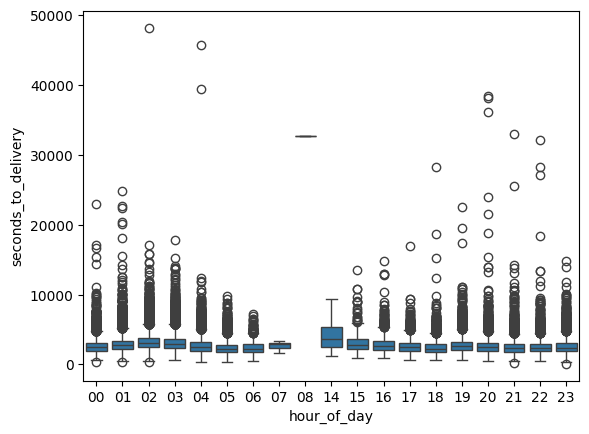

In [38]:
sns.boxplot(data=train_df, x="hour_of_day", y="seconds_to_delivery", order=sorted(train_df["hour_of_day"].unique()))

There still appears to be some orders with unusually long delivery times, but at least we can visualize the distribution across time of day now.

There doesn't seem to be any clear distinction as to which times of day result in the longest delivery orders. Additionally, it seems strange that we have no data on deliveries placed between 9 am - 2 pm. 

Let's revisit our numeric features w/ missing values:
- total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_store_to_consumer_driving_duration

For these features, let's impute missing values with the median:
- From the histograms above, these feature distributions appear to be skewed right, suggesting imputing by mean may be inappropriate.
- Very basic approach just to get data compatible with algorithm. Other approaches may involve imputing based on similar observations (KNN imputation), or building a regression model from related features (store, location, time of day) to predict the imputed values.

In [39]:
values = {
    'total_onshift_dashers': train_df['total_onshift_dashers'].median(), 
    'total_busy_dashers': train_df['total_busy_dashers'].median(),
    'total_outstanding_orders': train_df['total_outstanding_orders'].median(),
    'estimated_store_to_consumer_driving_duration': train_df['estimated_store_to_consumer_driving_duration'].median()
}
train_df.fillna(value=values, inplace=True)

Check collinearity among numeric features

In [40]:
train_df.columns

Index(['market_id', 'created_at', 'actual_delivery_time', 'store_id',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'seconds_to_delivery',
       'store_id_freq', 'store_category_type', 'item_price_range',
       'hour_of_day'],
      dtype='object')

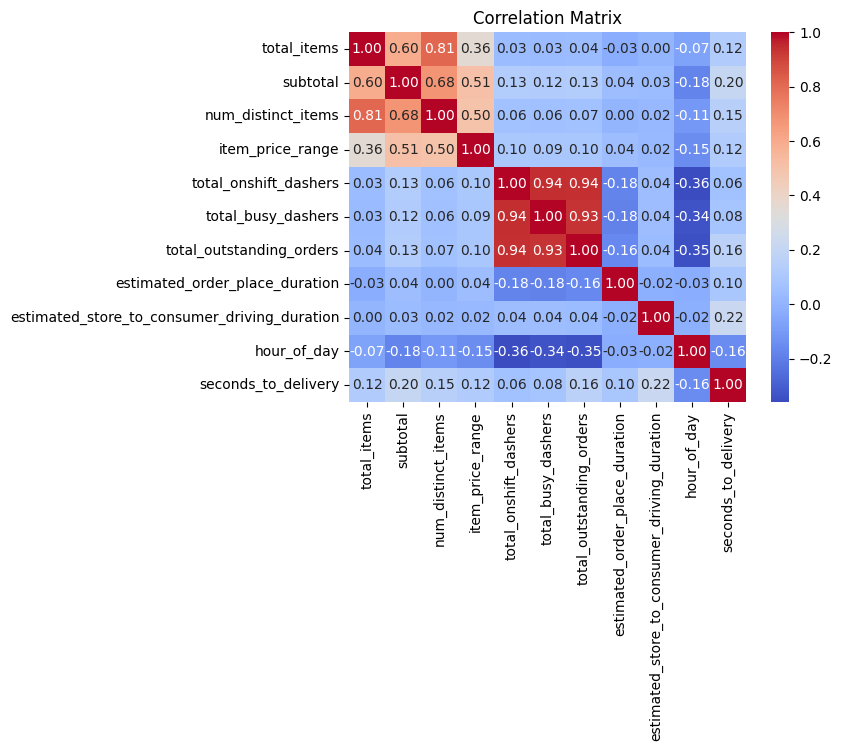

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = [
    'total_items',
    'subtotal',
    'num_distinct_items',
    'item_price_range',
    'total_onshift_dashers',
    'total_busy_dashers',
    'total_outstanding_orders', 
    'estimated_order_place_duration',
    'estimated_store_to_consumer_driving_duration',
    'hour_of_day',
]

target = 'seconds_to_delivery'

correlation_matrix = train_df[numeric_cols + [target]].corr()

# Heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

High collinearity among the following features:
- total_items & num_distinct_items (r > 0.8)
- total_onshift_dashers, total_busy_dashers, total_outstanding_orders (r > 0.9)

Some of the regression algorithms we will use for modeling assume absence of high collinearity.

So, among sets of highly collinear features, we will only keep one from each set for the final feature set for the model. We will drop correlated features as part of our preprocessing pipeline for our models.

Each of our numeric features show fairly weak correlation (r < 0.2) with our prediction target (seconds_to_delivery), which may give us a clue that a linear model will not effectively capture the relationship between the features & the target (if there is any relationship).

Let's write our cleaned, feature engineered data to separate csv for modeling.

In [42]:
clean_data_path = '../datasets/clean/train_data.csv'

train_df.to_csv(clean_data_path, index=False)

Sources:
- https://seaborn.pydata.org/api.html
- https://www.linkedin.com/advice/0/how-do-you-deal-categorical-features-high-cardinality#:~:text=One%20way%20to%20reduce%20the,Tashi%20Tamang
